# Analysis of deep mutational scanning of influenza PR8 M1

## Overview
This is deep mutational scanning by Nancy Hom of the M1 gene from A/PR/8/1934, in the context of the X31 (H3N2) virus.
Analysis by Lauren Gentles and Jesse Bloom.

## Import modules and define variables

In [1]:
import os
import warnings
warnings.simplefilter('ignore')
import numpy
import pandas
import glob
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown, Image
import dms_tools2
from dms_tools2 import AAS
import dms_tools2.dssp
import dms_tools2.prefs
import dms_tools2.plot
import dms_tools2.utils
import dms_tools2.sra
from dms_tools2.ipython_utils import showPDF

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

# results will go in this directory
resultsdir = './results/' 
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

Using dms_tools2 version 2.2.dev6


## Define Samples
There are three biological replicates.
For each replicate, there are four samples:
* DNA: unmutated plasmid (a control for sequencing error rate)
* mutDNA: the codon mutant plasmid libraries
* virus: virus grown from the unmutated plasmids (a control for reverse-transcription and viral replication errors)
* mutvirus: virus that has been passaged at low MOI to reveal selection in mutations in the mutDNA

In [2]:

samples = pandas.DataFrame.from_records([
          ('mutDNA-1', 'SRR7106940'),
          ('mutDNA-2', 'SRR7106941'),
          ('mutDNA-3', 'SRR7106938'),
          ('wtDNA-1', 'SRR7106939'),
          ('wtDNA-2', 'SRR7106936'),
          ('wtDNA-3', 'SRR7106937'),
          ('wtvirus-1', 'SRR7106934'),
          ('wtvirus-2', 'SRR7106935'),
          ('wtvirus-3', 'SRR7106932'),
          ('mutvirus-1', 'SRR7106933'),
          ('mutvirus-2', 'SRR7106930'),
          ('mutvirus-3', 'SRR7106931')],
        columns=['name', 'run'])

samples['R1'] = 'Sample_' + samples['name'] + '*' + '/' + samples['name'] + '*_R1*.fastq.gz'

display(HTML(samples.to_html(index=False)))

name,run,R1
mutDNA-1,SRR7106940,Sample_mutDNA-1*/mutDNA-1*_R1*.fastq.gz
mutDNA-2,SRR7106941,Sample_mutDNA-2*/mutDNA-2*_R1*.fastq.gz
mutDNA-3,SRR7106938,Sample_mutDNA-3*/mutDNA-3*_R1*.fastq.gz
wtDNA-1,SRR7106939,Sample_wtDNA-1*/wtDNA-1*_R1*.fastq.gz
wtDNA-2,SRR7106936,Sample_wtDNA-2*/wtDNA-2*_R1*.fastq.gz
wtDNA-3,SRR7106937,Sample_wtDNA-3*/wtDNA-3*_R1*.fastq.gz
wtvirus-1,SRR7106934,Sample_wtvirus-1*/wtvirus-1*_R1*.fastq.gz
wtvirus-2,SRR7106935,Sample_wtvirus-2*/wtvirus-2*_R1*.fastq.gz
wtvirus-3,SRR7106932,Sample_wtvirus-3*/wtvirus-3*_R1*.fastq.gz
mutvirus-1,SRR7106933,Sample_mutvirus-1*/mutvirus-1*_R1*.fastq.gz


## Download the FASTQ files from the SRA

The deep sequencing data are on Sequence Read Archive; here we download them for the following analysis.

We download these files using the fasqFromSRA function from the dms_tools2 Python API. Note that the call to this function below uses two external programs that are *not* part of dms_tools2, and which you therefore must install externally on the computer you are using:

   1. The fastq-dump program from the SRA Toolkit. If you do not already have this toolkit installed, you will need to install it by [following these intructions](https://trace.ncbi.nlm.nih.gov/Traces/sra/sra.cgi?view=toolkit_doc&f=std)
   2. The Aspera Connect program for rapid downloads. You need both the executable ascp and the Apera Key file. Installing the Apera Connect and key can be somewhat complex, so if you do not want to do this then just set `aspera=None` in the command below and the fastq-dump will do the downloads (albeit most slowly).

In [3]:
fastqdir = os.path.join(resultsdir, './FASTQ_files/')
print("Downloading FASTQ files from the SRA...")
dms_tools2.sra.fastqFromSRA(
        samples=samples,
        fastq_dump='fastq-dump', # valid path to this program on the Hutch server
        fastqdir=fastqdir,
        aspera=(
            '/app/aspera-connect/3.5.1/bin/ascp', # valid path to ascp on Hutch server
            '/app/aspera-connect/3.5.1/etc/asperaweb_id_dsa.openssh' # Aspera key on Hutch server
            )
        )
print("Here are the names of the downloaded files now found in {0}".format(fastqdir))
display(HTML(samples.to_html(index=False)))

Here are the names of the downloaded files now found in ./results/./FASTQ_files/


name,run,R1,R2
mutDNA-1,SRR7106940,mutDNA-1_R1.fastq.gz,mutDNA-1_R2.fastq.gz
mutDNA-2,SRR7106941,mutDNA-2_R1.fastq.gz,mutDNA-2_R2.fastq.gz
mutDNA-3,SRR7106938,mutDNA-3_R1.fastq.gz,mutDNA-3_R2.fastq.gz
wtDNA-1,SRR7106939,wtDNA-1_R1.fastq.gz,wtDNA-1_R2.fastq.gz
wtDNA-2,SRR7106936,wtDNA-2_R1.fastq.gz,wtDNA-2_R2.fastq.gz
wtDNA-3,SRR7106937,wtDNA-3_R1.fastq.gz,wtDNA-3_R2.fastq.gz
wtvirus-1,SRR7106934,wtvirus-1_R1.fastq.gz,wtvirus-1_R2.fastq.gz
wtvirus-2,SRR7106935,wtvirus-2_R1.fastq.gz,wtvirus-2_R2.fastq.gz
wtvirus-3,SRR7106932,wtvirus-3_R1.fastq.gz,wtvirus-3_R2.fastq.gz
mutvirus-1,SRR7106933,mutvirus-1_R1.fastq.gz,mutvirus-1_R2.fastq.gz


## Align the sequencing data to the count mutations

In [4]:
# file containing wildtype PR8 M1 sequence
refseq = './data/PR8-M1.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,252,34,27', '253,507,29,35', '508,759,29,30'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
samples.to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


Here are the names of the created codon counts files from running `dms2_batch_bcsubamp`:

In [5]:
!ls {countsdir}/*_codoncounts.csv

./results/codoncounts/mutDNA-1_codoncounts.csv
./results/codoncounts/mutDNA-2_codoncounts.csv
./results/codoncounts/mutDNA-3_codoncounts.csv
./results/codoncounts/mutvirus-1_codoncounts.csv
./results/codoncounts/mutvirus-2_codoncounts.csv
./results/codoncounts/mutvirus-3_codoncounts.csv
./results/codoncounts/wtDNA-1_codoncounts.csv
./results/codoncounts/wtDNA-2_codoncounts.csv
./results/codoncounts/wtDNA-3_codoncounts.csv
./results/codoncounts/wtvirus-1_codoncounts.csv
./results/codoncounts/wtvirus-2_codoncounts.csv
./results/codoncounts/wtvirus-3_codoncounts.csv


##  Look at the summary plots
Running `dms2_batch_bcsubamp` creates some summary plots. 
Here we look at them.

The `*_readstats.pdf` summary plot shows the number of reads that were retained or thrown away due to low quality barcodes. The black regions indicate reads that failed the Illumina filter.

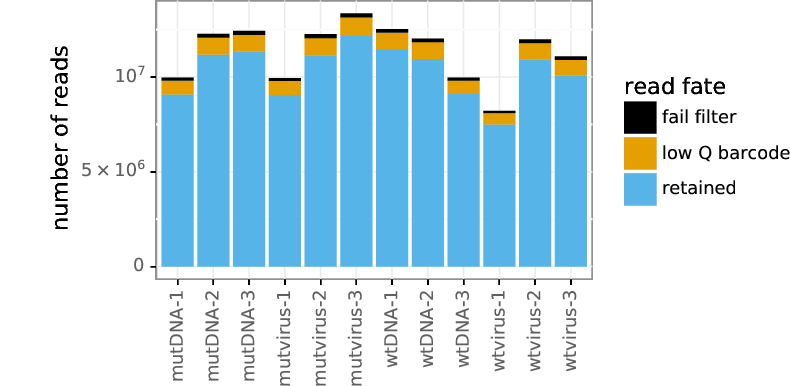

In [6]:
countsplotprefix = os.path.join(countsdir, 'summary')
showPDF(countsplotprefix + '_readstats.pdf', width=500)

The *_readsperbc.pdf summary plot shows the number of times each barcode was read for each sample.

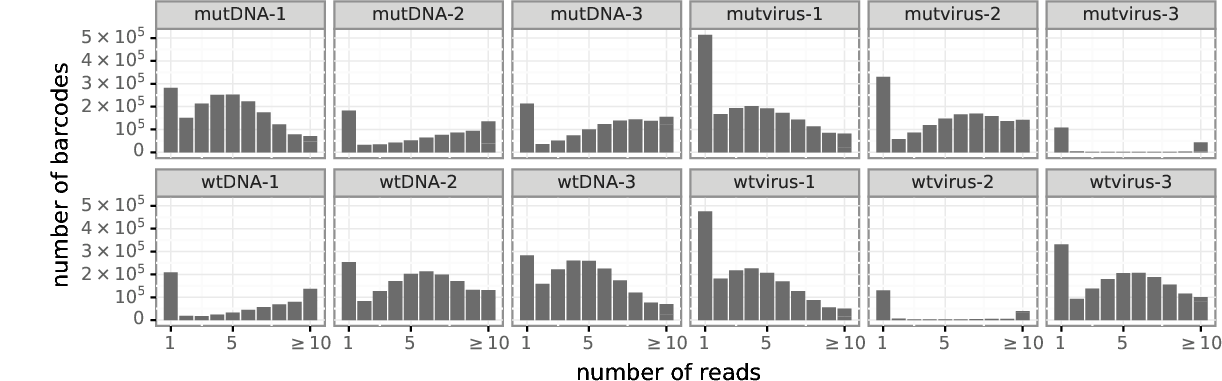

In [7]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` summary plot shows the number of barcodes that were able to be aligned to the reference WSN HA sequence. 
It will also show the number of barcodes that were not able to be alligned either because the barcode was not read enough times or the sequence just could not be aligned to the reference sequence.
We see from this plot and the one above that the *mutvirus-3* and *wtvirus-2* samples were sequencing to much less depth than the other samples, probably because too few barcodes were included when going from the round 1 to round 2 PCR.

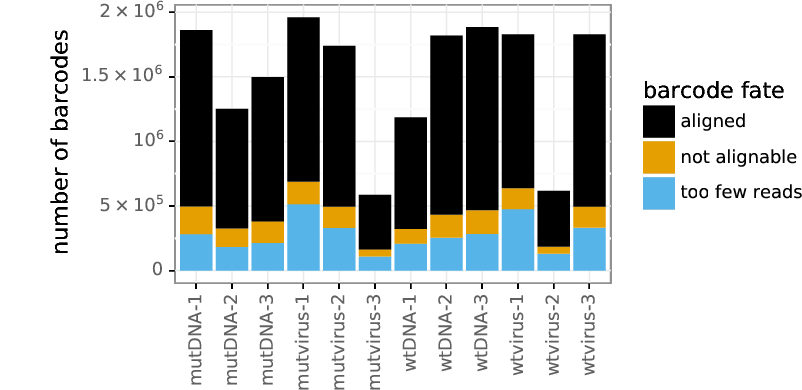

In [8]:
showPDF(countsplotprefix + '_bcstats.pdf', width=500)

The `*_depth.pdf` summary plot the depth (e.g. the number of reads for each codon) across the entire HA. 
This shows how well the barcodes were evenly represented between the different subamplicons.
We see that the sequencing was pretty even across the gene with a few exceptions (such as *mutvirus-1*). 
Every site seems to get > 100,000 reads even the two with lower overall depth.

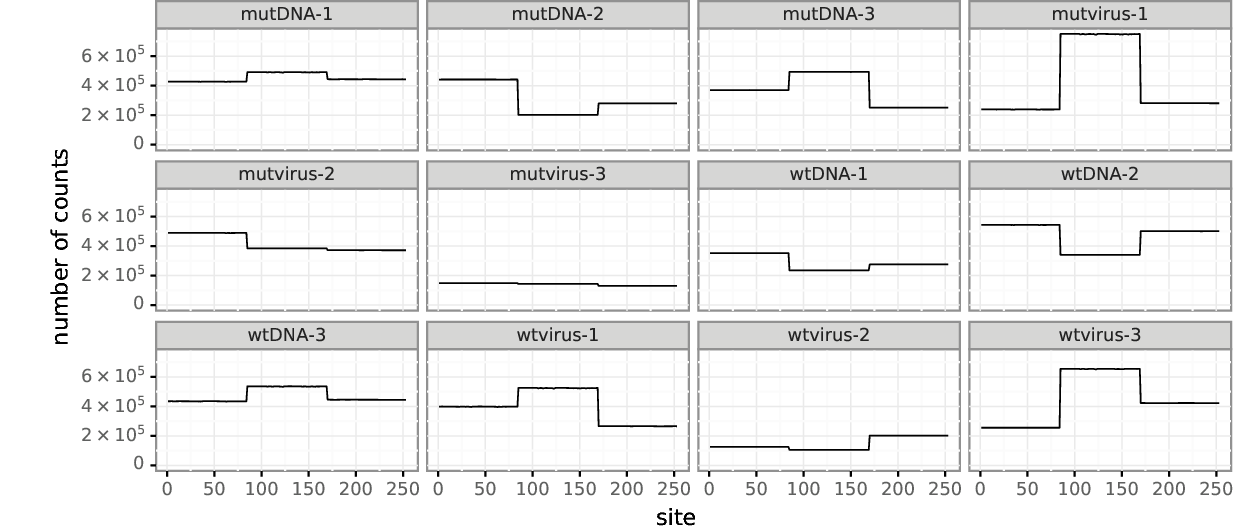

In [9]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` summary plot shows the per codon frequency of mutations at each site. 
In other words, it is the the cummulative number of mutations different from the reference sequence at each site.
These plots look good: there are mutations across the gene in the *mutDNA* samples, some are purged in the *mutvirus* samples, and there are very few apparent mutations in the wildtype controls.

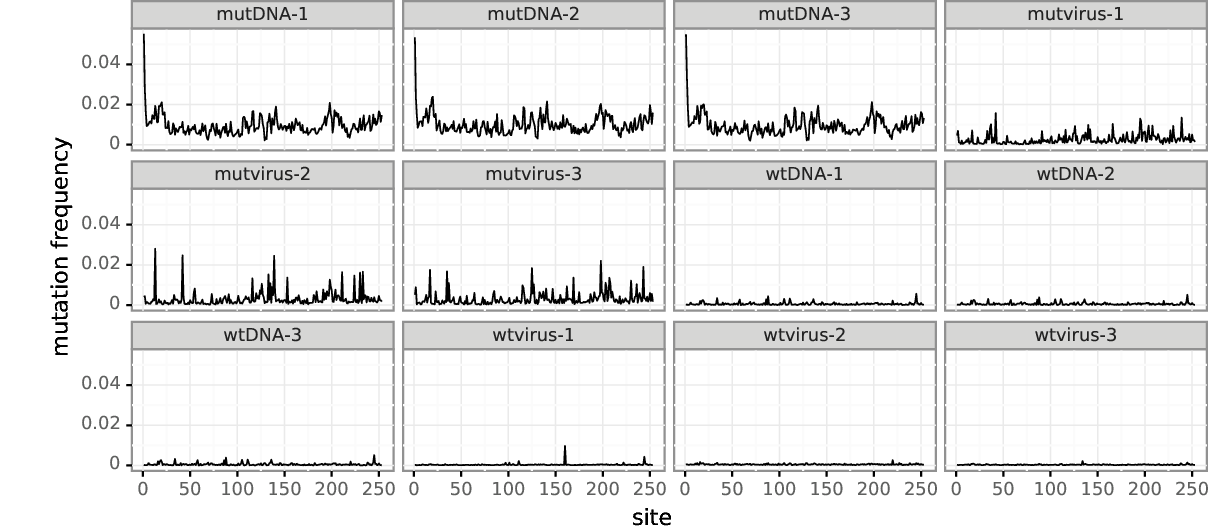

In [10]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_cumulmutcounts.pdf` plot below shows the fraction of mutations that are found less than or equal to the number of times indicated on the x-axis.
We can see from this plot that the *mutDNA* libraries did a very good job of sampling all the possible mutations.

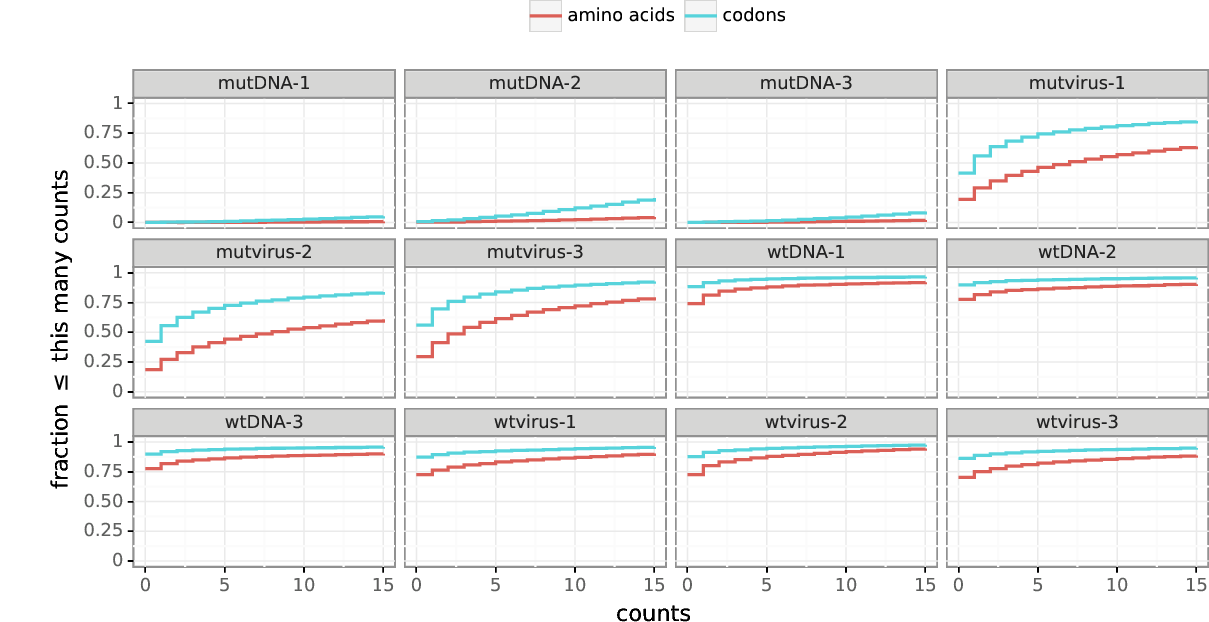

In [11]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

The *_codonmuttypes.pdf summary plot the per-codon frequency of nonsynonymous, synonymous, and stop codon mutation across the entire gene.

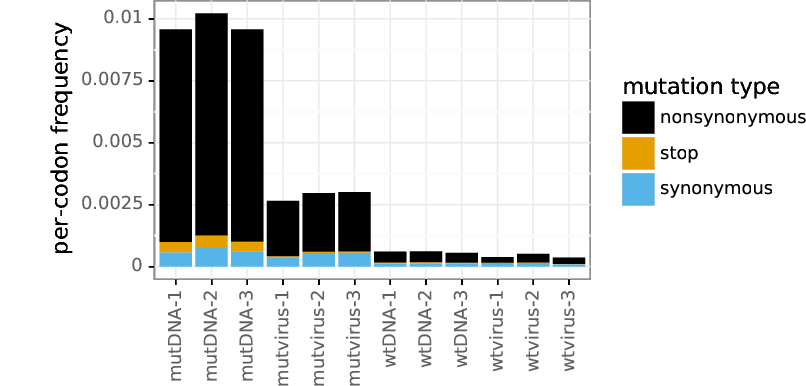

In [12]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=500)

The *_codonmuttypes.csv summary plot shows the nummerical values for the data above.

In [13]:
codonmuttypes = pandas.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
mutDNA-1,0.008580,0.000414,0.000578
mutDNA-2,0.008969,0.000498,0.000756
mutDNA-3,0.008576,0.000403,0.000602
mutvirus-1,0.002237,0.000049,0.000369
mutvirus-2,0.002368,0.000058,0.000544
mutvirus-3,0.002403,0.000048,0.000561
wtDNA-1,0.000431,0.000049,0.000123
wtDNA-2,0.000438,0.000050,0.000125
wtDNA-3,0.000399,0.000042,0.000113
wtvirus-1,0.000227,0.000012,0.000148


The *_codonntchanges.pdf summary plot shows the frequency of the number of nucleotide mutations that make up a given codon mutation (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides). 

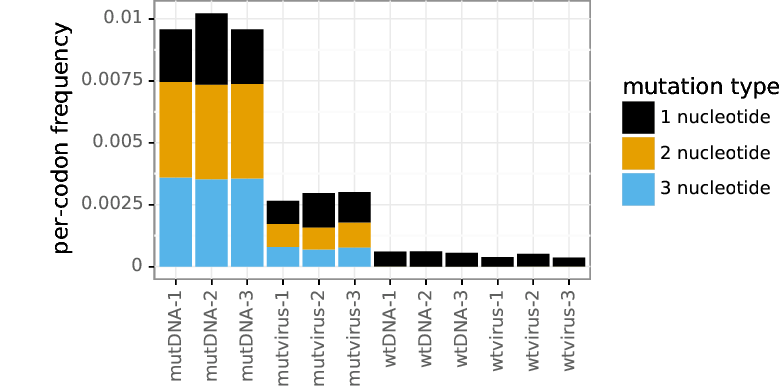

In [14]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=500)

The *_singlentchanges.pdf plot shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change.

This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). 

For instance, in the case of influenza, when we get bad oxidative damage, then we see an excess of C to A mutations in the final cDNA since the damage is occurring to a ssRNA genome. If you are sequencing something without polarity, you might see both types of mutations. Transitions (G <-> A and C <-> T) are a bit more common than most of the other types of mutations (all of which are transversions).

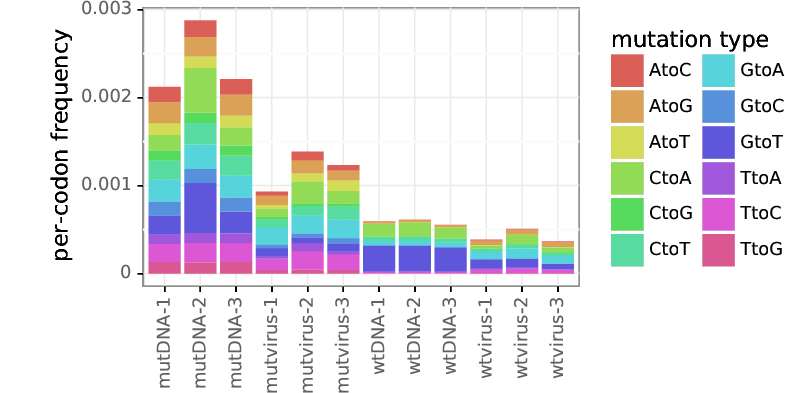

In [15]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=600)

## Estimate the amino acid preferences
Now we use `dms2_batch_prefs` to estimate the amino-acid preferences for each replicate.
We choose to use the *wtvirus* samples as both the pre- and post-selection error controls as it is apparent from the plot above that there is some oxidative damange in *wtDNA* samples that make their error rates higher than *wtvirus*.

In [16]:
# prefs placed in this directory
prefsdir = os.path.join(resultsdir, 'prefs')
if not os.path.isdir(prefsdir):
    os.mkdir(prefsdir)

# create batch file for dms2_batch_prefs
prefsbatch = pandas.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'mutDNA-1', 'mutvirus-1', 'wtvirus-1', 'wtvirus-1'),
              ('replicate-2', 'mutDNA-2', 'mutvirus-2', 'wtvirus-2', 'wtvirus-2'),
              ('replicate-3', 'mutDNA-3', 'mutvirus-3', 'wtvirus-3', 'wtvirus-3')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(prefsbatch.to_html(index=False)))
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing} 
print("Completed running dms2_batch_prefs")

Here is the batch file that we write to CSV format to use as input:


name,pre,post,errpre,errpost
replicate-1,mutDNA-1,mutvirus-1,wtvirus-1,wtvirus-1
replicate-2,mutDNA-2,mutvirus-2,wtvirus-2,wtvirus-2
replicate-3,mutDNA-3,mutvirus-3,wtvirus-3,wtvirus-3


Running dms2_batch_prefs...
Completed running dms2_batch_prefs


This creates files containing the estimated amino-acid preferences for each replicate. These preferences are in the directory specified by `--outdir` in the call to `dms2_batch_prefs` above.
There is also a file with the average preferences across replicates.

In [17]:
!ls {prefsdir}/*prefs.csv

./results/prefs/neff_and_prefs.csv     ./results/prefs/replicate-3_prefs.csv
./results/prefs/replicate-1_prefs.csv  ./results/prefs/summary_avgprefs.csv
./results/prefs/replicate-2_prefs.csv


The `*_prefscorr.pdf` file shows the correlation between all pairs of replicates specified in the batch file. 
Each point represents one amino acid preference, and the Pearson R is shown in the plot.
The correlations between replicates are substantial but still modest.
This is typical for deep mutational scanning of influenza virus using reverse genetics.
Typically the correlations are higher if a helper virus is used (see [Doud and Bloom (2016)](http://www.mdpi.com/1999-4915/8/6/155)), but that was not done here.

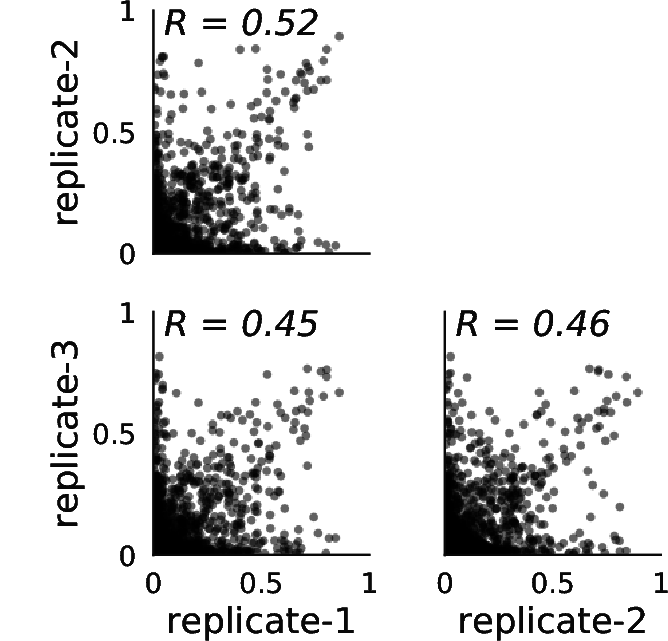

In [18]:
showPDF(os.path.join(prefsdir, 'summary_prefscorr.pdf'), width=300)

The dms2_batch_prefs creates a file with average preferences across replicates, with the prefix specified by --summaryprefix and suffix_avgprefs.csv. We can use dms2_logoplot to visualize thes average preferences in the form of a logo plot, where the height of each letter is proportional to the preference for that amino acid.

In [19]:
avgprefsfile = os.path.join(prefsdir, 'summary_avgprefs.csv')

This code takes a dssp file calculated from the PDB file for your protein of interest (in this case an M1 monomer) and allows the secondary structure to be overlayed ith the following logoplots.

In [20]:
dsspfile = './data/1EA3_monomer.dssp'
dssp_df = dms_tools2.dssp.processDSSP(dsspfile, chain='A')
dssp_df['SS'] = dssp_df['SS_class']
ssfile = os.path.join(prefsdir, 'SS.csv')
dssp_df[['site', 'SS']].to_csv(ssfile, index=False)
rsafile = os.path.join(prefsdir, 'RSA.csv')
dssp_df[['site', 'RSA']].to_csv(rsafile, index=False)

Now lets make a file with the wildtype sequence to use as an additonal overlay.

In [21]:
wtoverlayfile = os.path.join(prefsdir, 'wildtypeoverlayfile.csv')
aacounts = dms_tools2.utils.codonToAACounts(
        pandas.read_csv(os.path.join(countsdir, 'wtDNA-1_codoncounts.csv')))
aacounts.query('wildtype != "*"')[['site', 'wildtype']].to_csv(wtoverlayfile, index=False)

This will make a logo plot of the preferences for M1. I will add the secondary structure overlay once I have it running.

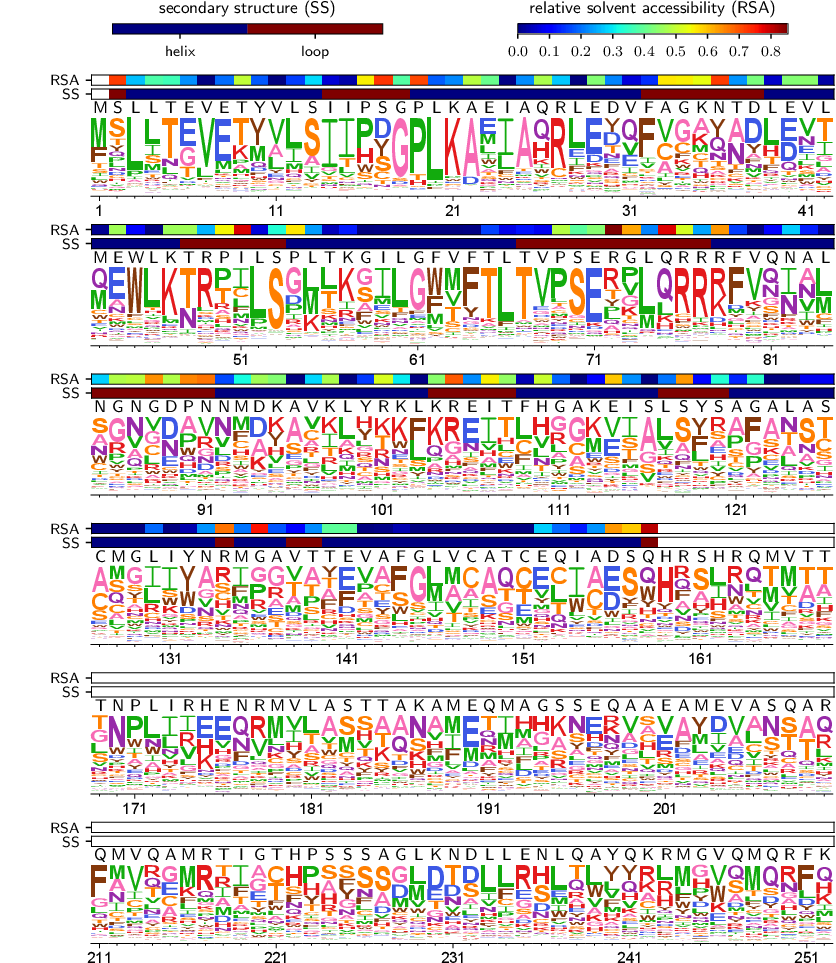

In [22]:
logoname = 'avgprefs'

log = !dms2_logoplot \
        --prefs {avgprefsfile} \
        --name {logoname} \
        --outdir {prefsdir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {ssfile} SS "secondary structure" \
        --overlay3 {rsafile} RSA "relative solvent accessibility" \
        --nperline 42 \
        --use_existing {use_existing}
        
logoplot = os.path.join(prefsdir, '{0}_prefs.pdf'.format(logoname))
showPDF(logoplot)

## Fit preferences to the evolution of natural HA sequences
Finally, we will take the averaged amino-acid preferences and fit them to natural sequence evolution. 
The goal here is to test the experimentally measured preferences are informative about natural sequence evolution, and if so obtain a stringency parameter that can be used to re-scale them to bring them into line with the stringency of natural selection.
We use a [sequence alignment](./data/M1_human_PR8_prealignment_fasta.fa) of human M1 coding sequences as compiled by [Machkovech et al (2015)](https://www.ncbi.nlm.nih.gov/pubmed/26311880).

In [23]:
print("Using the following version of phydms:")
!phydms -v

alignment = './data/M1_human_PR8_prealignment_fasta.fa'
phydms_dir = os.path.join(resultsdir, 'phydms_analysis/') # put phydms results here
modelcomparison = os.path.join(phydms_dir, 'modelcomparison.md')

if use_existing == 'yes' and os.path.isfile(modelcomparison):
    print("Results of phydms analysis already exist.")
else:
    print("Running phydms_comprehensive...")
    log = !phydms_comprehensive {phydms_dir} {alignment} {avgprefsfile} --raxml raxml
    print("Analysis complete.")

Using the following version of phydms:
phydms 2.2.0
Results of phydms analysis already exist.


The output of running `phydms_comprehensive` is a table that compares how well different models describe natural evolution.
The models are:
* The ExpCM model informed by the deep mutational scanning.
* A standard Goldman-Yang style model that allows the dN/dS ratio to vary across sites (the M5 model of YNGKP).
* A standard Goldman-Yang style model with a single dN/dS ratio (the M0 model of YNGKP).
* A "control" ExpCM in which the amino-acid preferences are averaged across sites to eliminate all site-specific information. Note that this is different than averaging the replicates to the get the "average preferences" -- here, the preferences are being averaged across sites, not replicates, so there is no longer any site-specific information.

If the deep mutational scanning is informative about evolution, then we expect the ExpCM to fit the natural sequence evolution much better than any of the other models. 
That is in fact what we see, as it has a much lower AIC.

Also of relevance is the stringency parameter ($\beta$) that re-scales the preferences to optimally fit natural evolution in an ExpCM. When $\beta > 1$, it means that natural evolution prefers the same amino acids as the experiments but with greater stringency (see Hilton and Bloom (2017), particularly Figure 3 of that paper, for more details).

In [24]:
display(Markdown(modelcomparison))

| Model                           | deltaAIC | LogLikelihood | nParams | ParamValues                                   |
|---------------------------------|----------|---------------|---------|-----------------------------------------------|
| ExpCM_summary_avgprefs          | 0.00     | -2192.25      | 6       | beta=1.96, kappa=8.00, omega=0.70             |
| YNGKP_M5                        | 964.92   | -2668.71      | 12      | alpha_omega=0.30, beta_omega=1.37, kappa=8.77 |
| averaged_ExpCM_summary_avgprefs | 991.64   | -2688.07      | 6       | beta=0.88, kappa=8.64, omega=0.18             |
| YNGKP_M0                        | 1034.84  | -2704.67      | 11      | kappa=8.49, omega=0.17                        |

We can now rescale our replicate-average preferences using the stringency parameter calculated using the ExpCM model. 
This re-scaling adjusts our experimental measurements to better reflect the stringency of selection in nature.

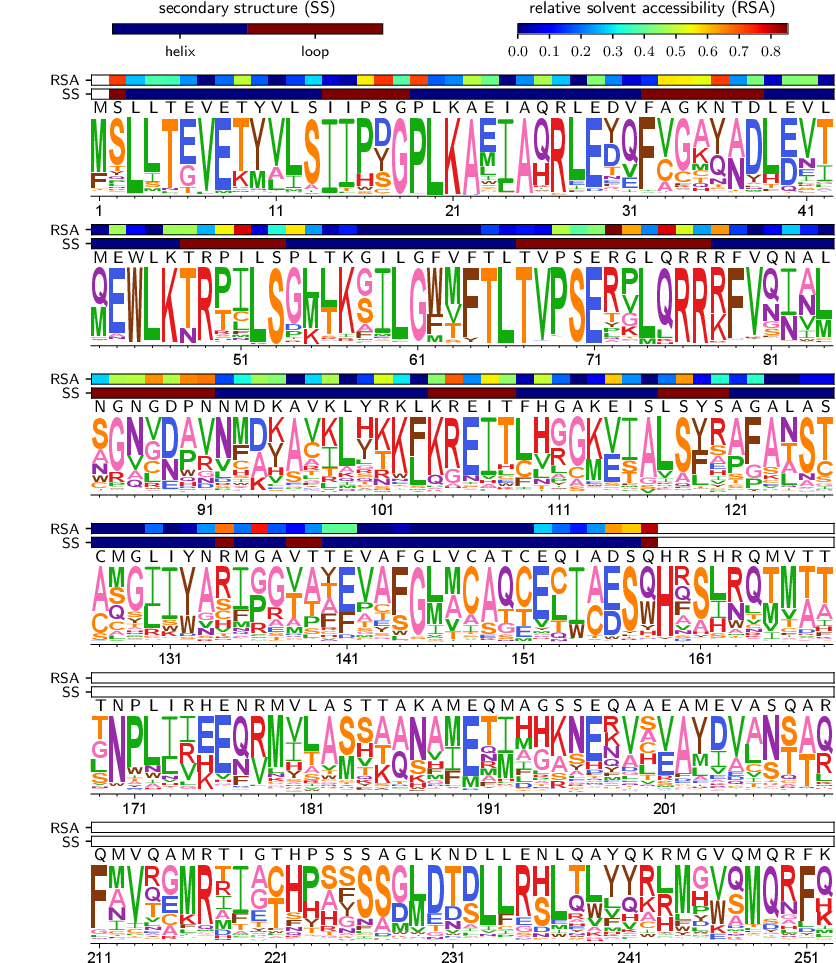

In [25]:
rescaledlogoname = 'rescaled-avgprefs'

log = !dms2_logoplot \
        --prefs {avgprefsfile} \
        --name {rescaledlogoname} \
        --outdir {prefsdir} \
        --overlay1 {wtoverlayfile} wildtype wildtype \
        --overlay2 {ssfile} SS "secondary structure" \
        --overlay3 {rsafile} RSA "relative solvent accessibility" \
        --nperline 42 \
        --stringency 1.96 \
        --use_existing {use_existing}
        
rescaledlogoplot = os.path.join(prefsdir, '{0}_prefs.pdf'.format(rescaledlogoname))
showPDF(rescaledlogoplot)

## Plot the mutational tolerance on the primary and 3D structure of M1
The preferences plot above makes clear that some sites tolerate a lot more amino acids than others.
We will define the mutational tolerance in terms of the *number of effective amino acids* at a site.
This is calculated as $N_{\rm{eff}} = \exp\left(-\sum_a \pi_{r,a} \log\left(\pi_{r,a}\right)\right)$ where $\pi_{r,a}$ is the preference of site $r$ for amino acid $a$.
When the number of effective amino acids is one, that means all the preference is for one amino acid at a site.
At the other extreme, when the number of effective amino acids is 20, the preferences are evenly distributed over all amino acids at a site.
In the calculations below, we use the re-scaled preferences.

First we compute the number of effective amino acids for each site using the re-scaled preferences, and write these to a file.

In [26]:
# read in preferences and re-scale by stringency parameter from above
prefs_df = dms_tools2.prefs.rescalePrefs(pandas.read_csv(avgprefsfile), 1.96)
# compute entropy and neffective
prefs_df = dms_tools2.prefs.prefsEntropy(prefs_df, AAS)

neff_file = os.path.join(prefsdir, 'neff_and_prefs.csv')
prefs_df.to_csv(neff_file, index=False)

Now we plot the number of effective amino acids as a function of primary sequence using [plotnine](https://plotnine.readthedocs.io/en/stable/).


Here is the plot with no smoothing:


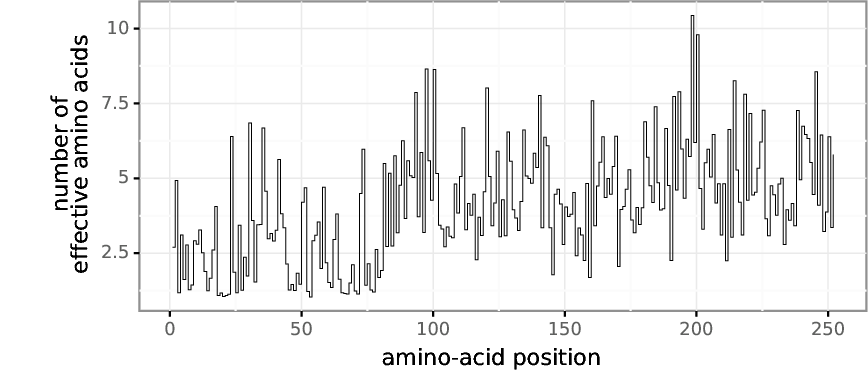


Here is the plot with smoothing:


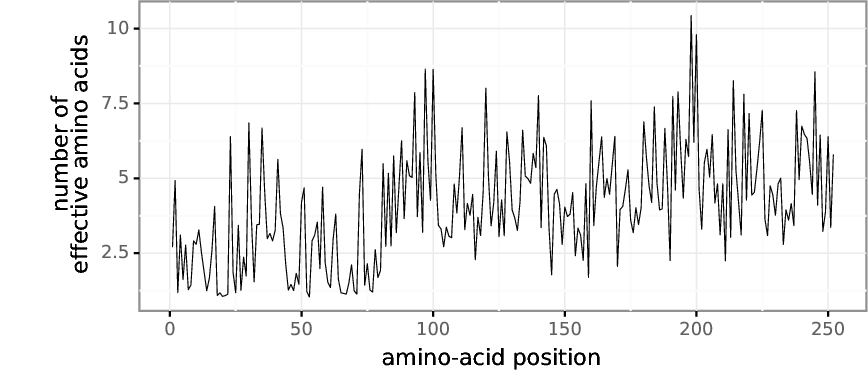

In [27]:
from plotnine import *
theme_set(theme_bw(base_size=12))

p = (ggplot(prefs_df, aes(x='site', y='neffective')) +
        ylab('number of\neffective amino acids') +
        xlab('amino-acid position') +
        theme(figure_size=(7, 3))
        )
p_nosmooth = p + geom_step(size=0.3)
p_smooth = p + geom_line(size=0.3)

nosmoothplotfile = os.path.join(prefsdir, 'neff_vs_site_nosmooth.pdf')
smoothplotfile = os.path.join(prefsdir, 'neff_vs_site_smooth.pdf')
p_nosmooth.save(nosmoothplotfile)
p_smooth.save(smoothplotfile)
print("\nHere is the plot with no smoothing:")
showPDF(nosmoothplotfile, width=600)
print('\nHere is the plot with smoothing:')
showPDF(smoothplotfile, width=600)

We can see from this plot how the mutational tolerance varies along primary sequence. 
In general, the N-terminal region is less mutationally tolerant than the C-terminal region.
The smoothed plot perhaps illustrates the point a bit better.

Now we will use [pymol](https://pymol.org/2/) to map the number of effective amino acids per site on the M1 crystal structure [1EA3](http://www.rcsb.org/pdb/explore.do?structureId=1ea3).

We do this using the script [./scripts/pymol_neff_color.py](./scripts/pymol_neff_color.py), which requires that you have `pymol` installed.
To run this command on the Hutch server, you need to move outside of the notebook and **manually** run the following two commands:

```module load PyMOL/1.8.0.0-foss-2015b-Python-2.7.9
pymol -c scripts/pymol_neff_color.py```

Running this command creates the file `results/prefs/structure_by_neff.png`, which we display below:

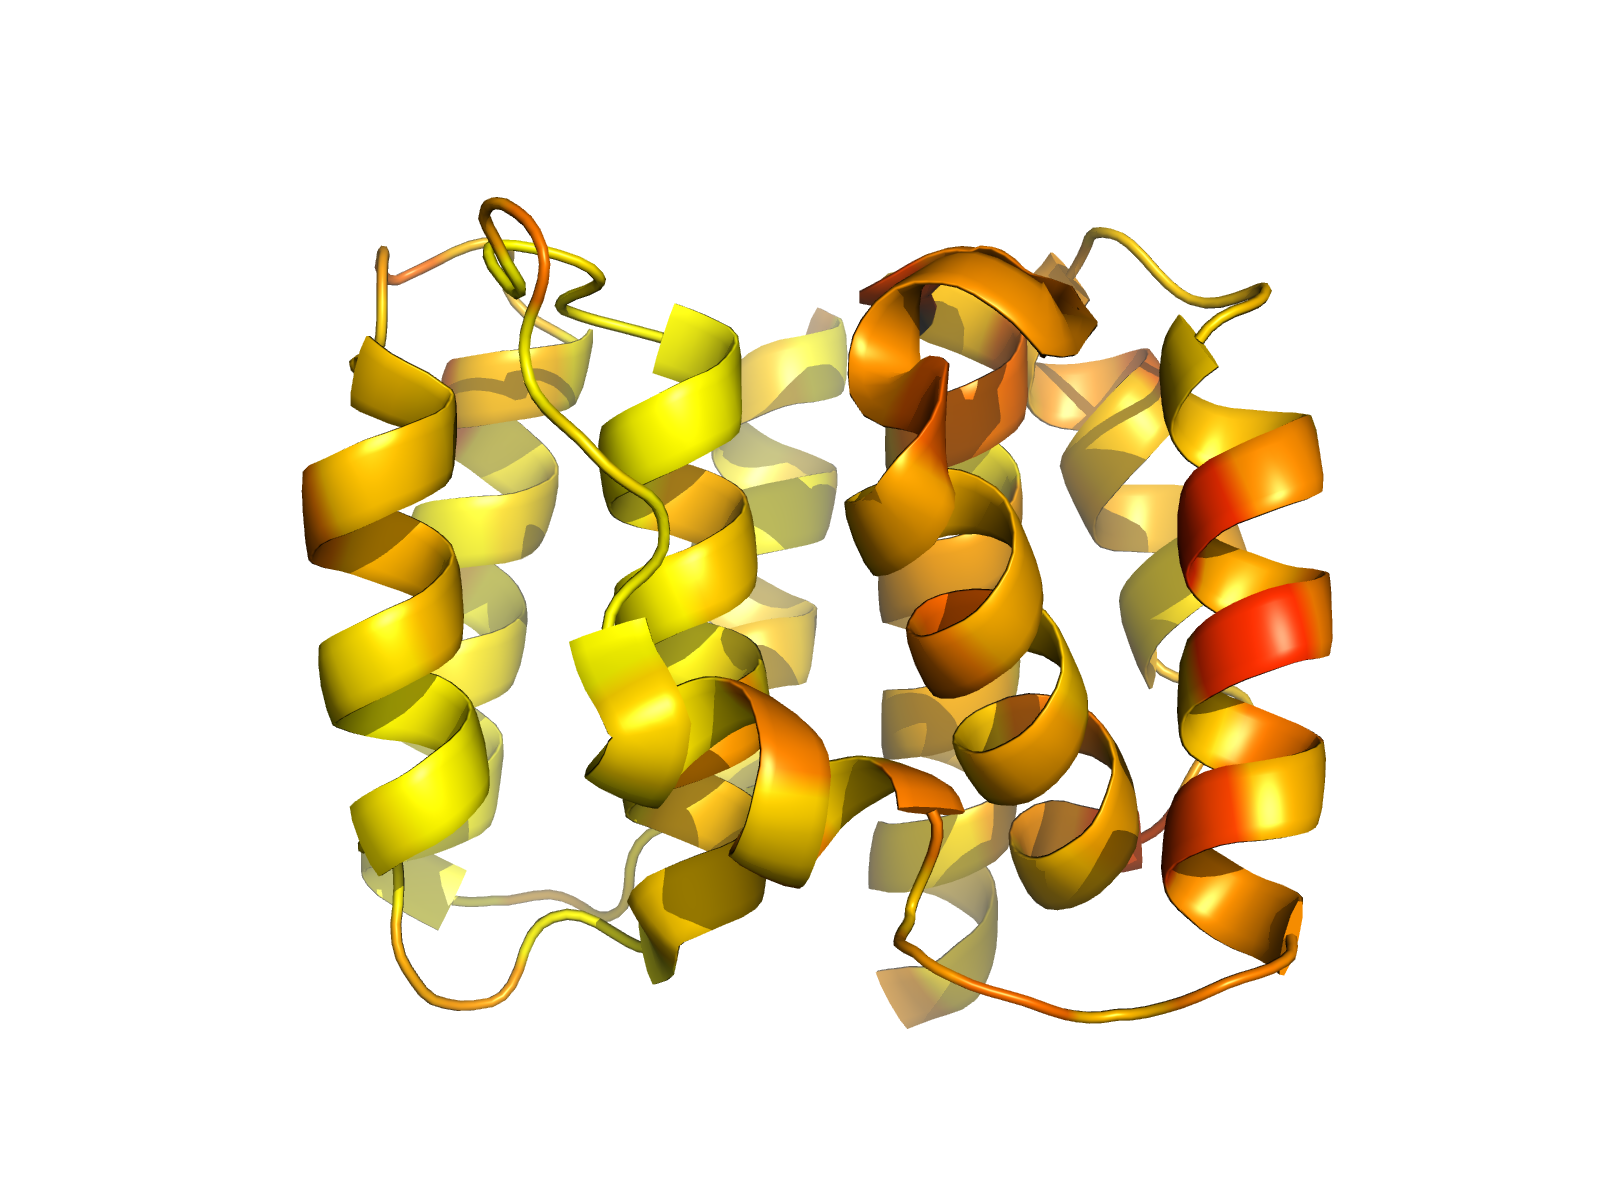

In [28]:
display(Image('results/prefs/structure_by_neff.png', width=500))

## Comparison of our DMS data with effects reported in Wu et al. 2016 BMC Genomics
[Wu et al (2016)](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-015-2358-7) also performed deep mutational scanning of M1.
Their study examined only some of the possible mutations to M1.
We want to compare our measured mutational effects to those from their experiemnts.
First we will read in the reported relative fitness effects from Wu et al.

In [29]:
wu_rf = pandas.read_csv('./data/Wu_relative_fitness.csv')
replicates = ['Rep{0}-RF_index'.format(i + 1) for i in range(5)]

for r in replicates:
    logr = 'log2_{0}'.format(r)
    wu_rf[logr] = numpy.log2(wu_rf[r])

We will now convert our DMS preference data into mutation effect sizes in order to compare the two data sets. 
(It is not possible to convert their mutation effect sizes into preferences since not all mutations were available for selection in their virus populations.)
The effect of a mutation from *x* to *y* is $\frac{\pi_{r,y}}{\pi_{r,x}}$ where $\pi_{r,x}$ is the preference of site $r$ for amino-acid $x$.

In [30]:
avgprefs = pandas.read_csv(avgprefsfile)
muteffects = dms_tools2.prefs.prefsToMutEffects(avgprefs, dms_tools2.AAS)

Now we correlate our values with the *maximum* RF (relative fitness) from the Wu et al study, as that is what they appear to think is their "best" measurement.
We do this correlation on the `log2` of the mutational effects.

The pearson correlation is 0.31
The spearman correlation is 0.32


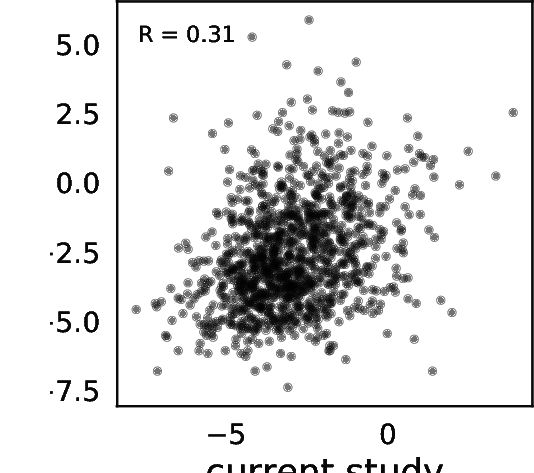

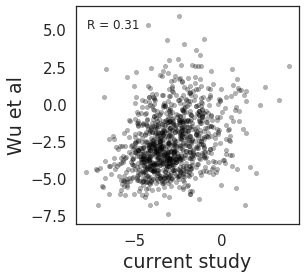

In [31]:
# dataframe with our values (log2 effects)
ourvalues = (
        muteffects.rename(columns={'log2effect':'current study'})
        .query('initial != final')
        [['mutation', 'current study']]
        .set_index('mutation')
        )

# data frame with Wu et al values (log2 effect)
wu_rf['log2'] = numpy.log2(wu_rf['RF_index(max)'])
wuvalues = (
        wu_rf
        .rename(columns={'M1':'mutation', 'log2':'Wu et al'})
        [['mutation', 'Wu et al']]
        .set_index('mutation')
        )

combinedeffects = wuvalues.join(ourvalues).dropna()
corrplot = os.path.join(prefsdir, 'Wu_et_al_correlation.pdf')
corr = {}
for corrmethod in ['pearson', 'spearman']:
    corr[corrmethod] = combinedeffects.corr(method=corrmethod).as_matrix()[0, 1]
    print("The {0} correlation is {1:.2f}".format(corrmethod, corr[corrmethod]))

ax = combinedeffects.plot.scatter(x='current study', y='Wu et al', 
        color='black', alpha=0.3, figsize=(4, 4))
ax.annotate('R = {0:.2f}'.format(corr['pearson']), (0.05, 0.9), 
        xycoords='axes fraction', size=12)
plt.savefig(corrplot)

showPDF(corrplot, width=400)

The Pearson correlation between our measurements and those of Wu et al is 0.31, and the Spearman correlation is 0.32. 
In comparison, according to their paper ([Table 2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4710013/table/Tab2/)), Wu et al have a Spearman correlation among their replicates that ranges from 0.53 to 0.67.
The Pearson correlation among our replicates ranges from 0.45 to 0.52 (see plot above).
So overall, our values are substantially correlated with theirs but not quite as correlated as within studies.